# Instagram data fake accounts
Fuente: https://www.kaggle.com/free4ever1/instagram-fake-spammer-genuine-accounts#

In [1]:
### Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import random
import re
from functools import reduce
%matplotlib inline

In [2]:
### Cargar el dataset 
train_data = pd.read_csv('resources/train.csv')
test_data = pd.read_csv('resources/test.csv')
train_data.sample(10)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
196,1,0.00,2,0.00,0,48,0,0,222,5282,652,0
425,0,0.50,1,0.00,0,0,0,0,0,17,44,1
547,0,0.57,1,0.57,1,0,0,0,2,34,112,1
379,1,0.30,1,0.00,0,5,0,1,1,51,420,1
264,1,0.00,2,0.00,0,12,0,0,197,1070,1072,0
317,0,0.00,2,0.00,0,0,0,1,0,51,126,1
567,1,0.25,1,0.00,0,0,0,1,102,39,229,1
101,1,0.00,0,0.00,0,0,0,1,28,59,55,0
95,1,0.00,2,0.00,0,73,0,1,232,1312,935,0
287,1,0.00,2,0.00,0,0,0,1,30,56,114,0


In [3]:
### Tamaño del dataset
size_dataset = len(train_data)
size_dataset_test = len(test_data)
print("Tamaño del dataset_train (filas): " + str(size_dataset))
print("Tamaño del dataset_test (filas): " + str(size_dataset_test))

Tamaño del dataset_train (filas): 576
Tamaño del dataset_test (filas): 120


In [4]:
### Canviar nombres de columnas
train_data.rename(columns={'profile pic':'profile_pic'}, inplace=True)
train_data.rename(columns={'description length':'description_length'}, inplace=True)
train_data.rename(columns={'#posts':'posts'}, inplace=True)

In [5]:
### Canviar el orden de las columnas
train_data = train_data[['profile_pic', 'private', 'name==username', 'external URL','nums/length username', \
                             'fullname words','nums/length fullname','description_length','posts','#followers', \
                             '#follows', 'fake']]

In [6]:
train_data.sample(10)

,profile_pic,private,name==username,external URL,nums/length username,fullname words,nums/length fullname,description_length,posts,#followers,#follows,fake
188,1,0,0,0,0.00,2,0.0,0,5,135,176,0
44,1,0,0,0,0.00,4,0.0,35,4494,12397719,8,0
454,1,1,1,0,0.00,1,0.0,34,0,16,17,1
39,1,0,0,0,0.00,2,0.0,0,8,105,98,0
130,1,0,0,1,0.00,4,0.0,150,161,1383,7500,0
349,1,0,0,0,0.00,1,0.0,10,9,59,48,1
158,1,1,0,0,0.00,2,0.0,12,8,303,417,0
416,1,0,0,0,0.33,2,0.0,0,25,70,64,1
153,1,0,0,0,0.00,2,0.0,87,131,1662,1065,0
313,0,1,0,0,0.00,1,0.0,0,1,107,42,1


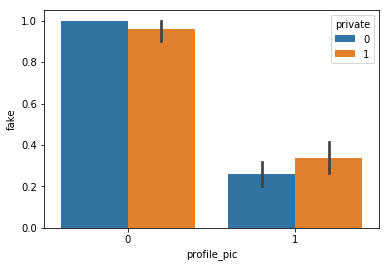

In [7]:
### Grafico si tiene foto de perfil o no vs fake (y si la cuenta es privada o no)
sns.barplot(x='profile_pic', y='fake', hue='private', data=train_data)
plt.show()

> Vemos que si no tiene foto de perfil tanto si la cuenta es privada como no, la cuenta muy probablemente sea falsa. En cambio,
si tiene foto de perfil es más probable que la cuenta sea auténtica.

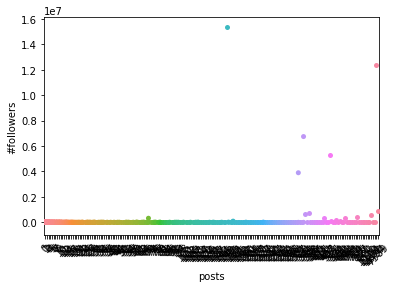

In [8]:
### Grafico posts vs followers
sns.swarmplot(x='posts', y='#followers', data=train_data)
plt.xticks(rotation=45)
plt.show()

> Los posts se solapan entre ellos, así que vamos a crear categorías por rangos de esta variable. Y la añadiremos como una nueva columna, "posts_cat".

In [9]:
# Creación de categorías por rangos de la variable "posts"
def cat_posts(data):
    posts_cat = data['posts']
    train_data.insert(9, 'posts_cat', posts_cat)
    posts_cat = data['posts_cat'].fillna(-0.5)
    bins = [-1, -0.1, 0, 10, 50, 100, 150, 200, 500, 1000, 2000, 5000, 7000, 10000]
    cat_names = ['Unknown','0','1-10','10-50','50-100','100-150','150-200','200-500','500-1k','1k-2k','2k-5k','5k-7k','7k-10k']
    categories = pd.cut(data['posts_cat'],bins,labels=cat_names)
    data['posts_cat'] = categories
    return data

train_data = cat_posts(train_data)

In [10]:
# Comprovación de valores NaN en posts
mask_unknown = train_data['posts_cat'] == 'Unknown'
train_data_unknown = train_data[mask_unknown]
len(train_data_unknown)


0

> No tenemos ningun valor Nan en la categoría posts.

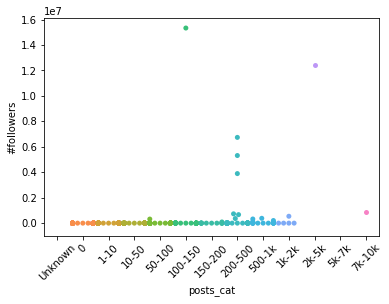

In [11]:
# Grafico posts_cat vs followers
sns.swarmplot(x='posts_cat', y='#followers', data=train_data)
plt.xticks(rotation=45)
plt.show()

> No podemos apreciar bien el gráfico debido a que hay mucha diferencia entre los valores mas comunes de followers y los más elevados. Así que sólo nos quedaremos, con los más comunes. 

In [12]:
# Nos quedamos solo con las cuentas que tengan menos de 10 mil seguidores
mask_1 = train_data['#followers'] <= 10000
train_data_mask1 = train_data[mask_1]
n_accounts_10k_followers = len(train_data_mask1)
print("Cuentas con menos de 10k seguidores: " + str(n_accounts_10k_followers))


Cuentas con menos de 10k seguidores: 542


> El tamaño del dataset es de 576, así que el valor de 10k de seguidores, es un valor correcto debido a que no despreciamos muchas filas del dataset.

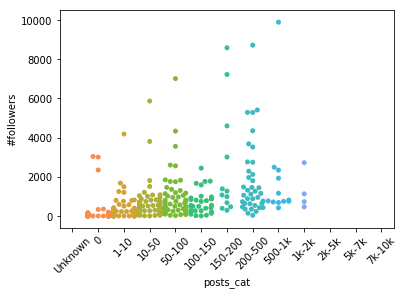

In [13]:
# Grafico posts_cat vs followers (procesado)
sns.swarmplot(x='posts_cat', y='#followers', data=train_data_mask1)
plt.xticks(rotation=45)
plt.show()

> Ahora si podemos visualizar de manera correcta el gráfico.

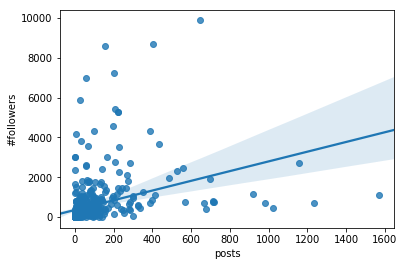

In [14]:
# Correlación entre posts y followers
sns.regplot(x="posts", y="#followers", data=train_data_mask1, order = 1)
plt.show()

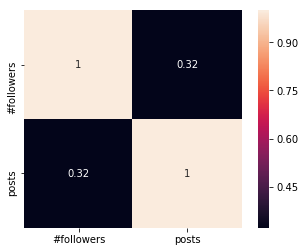

In [15]:
followers_posts_data = train_data[['#followers', 'posts']].copy() # nos quedamo sólo con las columnas de followers y posts
sns.heatmap(followers_posts_data.corr(), square=True, annot=True)

> Miramos la correlación entre estas dos variables, y como podemos observar, la correlación es baja.

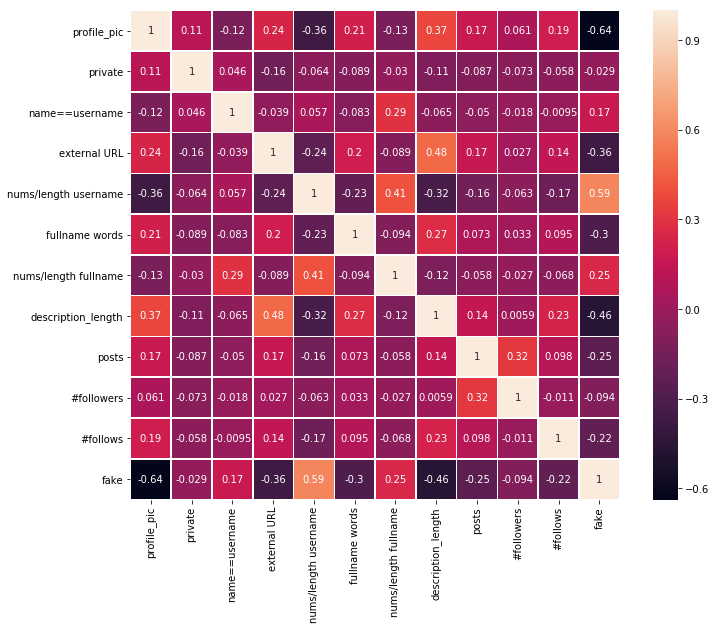

In [16]:
### Correlación de las variables del dataset
plt.figure(figsize=(12, 9)) # tamaño de la figura
sns.heatmap(train_data.corr(), square=True, annot=True, linewidths=.5)

> Las 2 variables que estan más correlocianadas entre si, són la "nums/length username" y "fake".

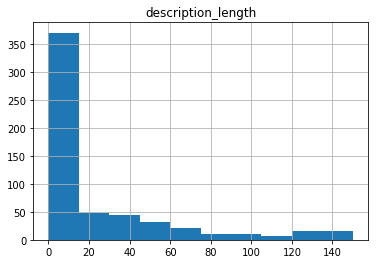

In [17]:
### Histograma de description_length
hist = train_data.hist(column = 'description_length')

> Hay muchas cuentas que no tienen descripción y no podemos analizar bien la longitud de la descripción de las cuentas que si tienen descripción. Así que quitamos las cuentas que no tienen descripción

In [18]:
# quitamos los que no tienen descripción
mask_desc_leng = train_data['description_length'] > 0
data_desc_leng = train_data[mask_desc_leng]

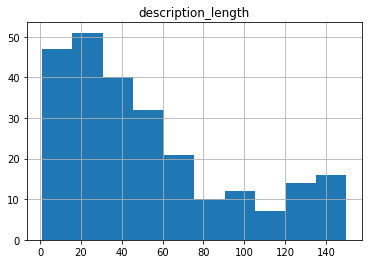

In [19]:
# histograma description_lenght (solo con los que tienen descripción)
hist = data_desc_leng.hist(column = 'description_length')

> Ahora podemos apreciar mejor los valores de la longitud de la descripción. 

· Representación gráfica:


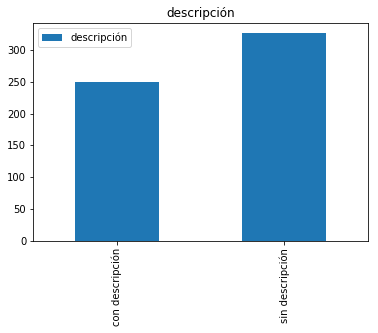

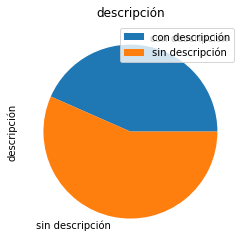

- Cuentas con descripción: 250 (43.40277777777778 %)
- Cuentas sin descripción: 326 (56.59722222222222 %)


In [20]:
# Número de cuentas con y sin descripción 
n_description_length_yes = len(data_desc_leng)
n_description_length_yes_100 = (n_description_length_yes/size_dataset)*100

n_description_length_no = size_dataset - n_description_length_yes
n_description_length_no_100 = (n_description_length_no/size_dataset)*100

# Representación gráfica
print("· Representación gráfica:")
df = pd.DataFrame({'descripción': [n_description_length_yes, n_description_length_no]}, index=['con descripción',\
                                                                                           'sin descripción'])

df.plot(y='descripción',kind='bar',title='descripción')
df.plot(y='descripción',kind='pie',title='descripción')
plt.show()

print("- Cuentas con descripción: " + str(n_description_length_yes) + " (" + str(n_description_length_yes_100) + " %)")
print("- Cuentas sin descripción: " + str(n_description_length_no) + " (" + str(n_description_length_no_100) + " %)")

> Más de la mitad de cuentas (56,6 %) no tiene descripción.

In [21]:
### Cual es el número de carácteres de la descripción más frecuente (valor repetido más veces)?
dictionary = {}
maximum = 0
def frec(data):
    global dictionary, maximum # las declaro globales, para acceder a ellas
    list_result_frec = []
    list_i = range(0,150)
    for i in range (0,150):
        list_result_frec.append(data.isin([i]).values.sum())
    dictionary = dict(zip(list_i, list_result_frec))    
    maximum = max(dictionary, key=dictionary.get)
    return {print("Diccionario con los resultados:" + '\n' + str(dictionary)),
            print('\n' + "- Description_length mas repetido: " + str(maximum) + " carácteres"), 
            print("- Nº de veces repetido: " + str(dictionary[maximum]))}

frec(data_desc_leng.description_length)

Diccionario con los resultados:
{0: 0, 1: 4, 2: 7, 3: 2, 4: 2, 5: 5, 6: 3, 7: 1, 8: 2, 9: 4, 10: 2, 11: 3, 12: 6, 13: 3, 14: 1, 15: 2, 16: 1, 17: 2, 18: 5, 19: 6, 20: 3, 21: 2, 22: 2, 23: 6, 24: 4, 25: 1, 26: 6, 27: 3, 28: 4, 29: 1, 30: 5, 31: 1, 32: 2, 33: 2, 34: 5, 35: 8, 36: 1, 37: 3, 38: 1, 39: 3, 40: 4, 41: 0, 42: 2, 43: 5, 44: 3, 45: 0, 46: 4, 47: 0, 48: 3, 49: 1, 50: 6, 51: 2, 52: 0, 53: 2, 54: 4, 55: 2, 56: 1, 57: 2, 58: 1, 59: 4, 60: 0, 61: 2, 62: 2, 63: 1, 64: 2, 65: 0, 66: 0, 67: 2, 68: 1, 69: 0, 70: 3, 71: 3, 72: 1, 73: 2, 74: 2, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 1, 81: 3, 82: 2, 83: 0, 84: 0, 85: 0, 86: 2, 87: 1, 88: 0, 89: 1, 90: 0, 91: 3, 92: 0, 93: 1, 94: 0, 95: 1, 96: 1, 97: 0, 98: 2, 99: 0, 100: 0, 101: 1, 102: 0, 103: 2, 104: 0, 105: 1, 106: 1, 107: 0, 108: 1, 109: 1, 110: 0, 111: 0, 112: 1, 113: 1, 114: 0, 115: 0, 116: 0, 117: 1, 118: 0, 119: 0, 120: 1, 121: 0, 122: 2, 123: 3, 124: 0, 125: 0, 126: 2, 127: 0, 128: 0, 129: 2, 130: 0, 131: 1, 132: 1, 133: 1, 134: 

{None}

In [22]:
# Hay algun otro description_length que este repetido 8 veces?
maximum_list = [i for i,j in dictionary.items() if j == dictionary[maximum]] 
len(maximum_list)

1

> Como podemos ver sólo está repetido 8 veces la description_length de 35 carácteres. Está comprobación se hace para mirar si habia otro valor de description_lenght que se repitiese también 8 veces.

In [23]:
### Cuantas cuentas hay fake y cuantas reales

# Mask Fake
mask_fake = train_data['fake'] == 1
train_data_fake = train_data[mask_fake]

# Mask Real
mask_real = train_data['fake'] == 0
train_data_real = train_data[mask_real]

# Lista de las variables
list_variables = ['nums/length username','fullname words','nums/length fullname','description_length', 'posts','#followers'\
               ,'#follows']

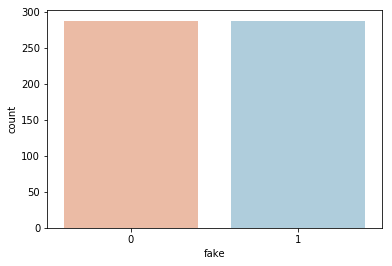

- Nº de cuentas fake (naranja):288
- Nº de cuentas autenticas (azul):288


In [24]:
### Cuantas cuentas hay fake y cuantas reales

# - De manera gráfica:
sns.countplot(x='fake',data=train_data, palette = "RdBu")
plt.show()

# - Con números:
n_fake_accounts = len(train_data_fake)
n_genuine_accounts = len(train_data_real)
print("- Nº de cuentas fake (naranja):" + str(n_fake_accounts))
print("- Nº de cuentas autenticas (azul):" + str(n_genuine_accounts))


> Tenemos la mitad de cuentas falsas y la mitad de auténticas.

In [25]:
### Valor mínimo, media, desviación y valor máximo (de las variables numéricas)
list_min = []
list_mean = []
list_std = []
list_max = []

for i in list_variables:
    list_min.append(train_data[i].min())
    list_mean.append(train_data[i].mean())
    list_std.append(train_data[i].std())
    list_max.append(train_data[i].max())

# Ponemos los resultados en un dataframe
data = {'min': list_min, 'mean': list_mean, 'std': list_std, 'max': list_max}
df = pd.DataFrame(data)
df.insert(0, 'variables', list_variables)
df

,variables,min,mean,std,max
0,nums/length username,0.0,0.163837,0.214096,0.92
1,fullname words,0.0,1.460069,1.052601,12.00
2,nums/length fullname,0.0,0.036094,0.125121,1.00
3,description_length,0.0,22.623264,37.702987,150.00
4,posts,0.0,107.489583,402.034431,7389.00
5,#followers,0.0,85307.236111,910148.457657,15338538.00
6,#follows,0.0,508.381944,917.981239,7500.00


In [26]:
# Cuentas auténticas
list_min_real = []
list_mean_real = []
list_std_real = []
list_max_real = []

for i in list_variables:
    list_min_real.append(train_data_real[i].min())
    list_mean_real.append(train_data_real[i].mean())
    list_std_real.append(train_data_real[i].std())
    list_max_real.append(train_data_real[i].max())

# Ponemos los resultados en un dataframe
data_real = {'min': list_min_real, 'mean': list_mean_real, 'std': list_std_real, 'max': list_max_real}
df_real = pd.DataFrame(data_real)
df_real.insert(0, 'variables', list_variables)
df_real

,variables,min,mean,std,max
0,nums/length username,0.0,0.038125,8.859310e-02,0.45
1,fullname words,0.0,1.774306,1.249850e+00,12.00
2,nums/length fullname,0.0,0.005243,3.411310e-02,0.33
3,description_length,0.0,39.982639,4.279385e+01,150.00
4,posts,0.0,206.045139,5.509518e+02,7389.00
5,#followers,9.0,170503.885417,1.282599e+06,15338538.00
6,#follows,0.0,714.597222,1.051598e+03,7500.00


In [27]:
# Cuentas fake
list_min_fake = []
list_mean_fake = []
list_std_fake = []
list_max_fake = []

for i in list_variables:
    list_min_fake.append(train_data_fake[i].min())
    list_mean_fake.append(train_data_fake[i].mean())
    list_std_fake.append(train_data_fake[i].std())
    list_max_fake.append(train_data_fake[i].max())

# Ponemos los resultados en un dataframe
data_fake = {'min': list_min_fake, 'mean': list_mean_fake, 'std': list_std_fake, 'max': list_max_fake}
df_fake = pd.DataFrame(data_fake)
df_fake.insert(0, 'variables', list_variables)
df_fake

,variables,min,mean,std,max
0,nums/length username,0.0,0.289549,0.228621,0.92
1,fullname words,0.0,1.145833,0.677860,5.00
2,nums/length fullname,0.0,0.066944,0.168199,1.00
3,description_length,0.0,5.263889,20.294688,149.00
4,posts,0.0,8.934028,28.009316,299.00
5,#followers,0.0,110.586806,318.407808,3033.00
6,#follows,0.0,302.166667,705.060607,7272.00


> En general los valores de las cuentas falsas son inferiores.

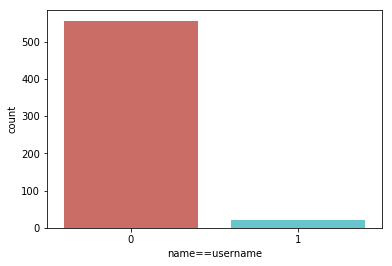

- Nº de cuentas el name coincide con el username: 20
- % name=username respecto al total del dataset: 3.4722222222222223 %


In [28]:
### Cuantas cuentas el name coincide con el username?

# - De manera gráfica:
sns.countplot(x='name==username',data=train_data, palette="hls")
plt.show()

# - Con números:
mask_name_username = train_data['name==username'] == 1
train_data_name_username = train_data[mask_name_username]
n_name_username = len(train_data_name_username)
print("- Nº de cuentas el name coincide con el username: " + str(n_name_username))

# % sobre el total del dataset
print("- % name=username respecto al total del dataset: " + str((n_name_username/size_dataset)*100) + " %")


> Pocas cuentas el nombre de usuario coincide con el nombre de la cuenta.

- Nº de cuentas el name coincide con el username y son fake: 19

· Representación gráfica:


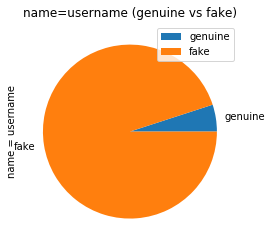

- % name=username fake respecto al total de name = username (naranja): 95.0 %


In [29]:
# Cuantas de ellas son fake?
mask_nu_fake = train_data_name_username['fake'] == 1
train_data_nu_fake = train_data_name_username[mask_nu_fake]
n_name_username_fake = len(train_data_nu_fake)
n_name_username_genuine = n_name_username - n_name_username_fake
print("- Nº de cuentas el name coincide con el username y son fake: " + str(n_name_username_fake))

# Representación gráfica
print('\n' + "· Representación gráfica:")
df = pd.DataFrame({'name = username': [n_name_username_genuine, n_name_username_fake]}, index=['genuine', 'fake'])
df.plot(y='name = username',kind='pie',title='name=username (genuine vs fake)')
plt.show()

# % respecto el total de name = username
print("- % name=username fake respecto al total de name = username (naranja): " + str((n_name_username_fake/n_name_username)\
                                                                                      *100) + " %")

> Vemos que si el nombre de usuario concide con el nombre de la cuenta lo más seguro es que la cuenta sea fake.

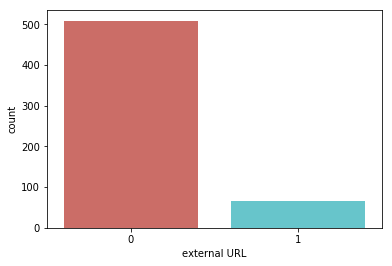

- Nº de cuentas que tienen external URL: 67
- % external URL respecto al total del dataset: 11.631944444444445 %


In [30]:
### Cuantas cuentas tienen external URL?

# - De manera gráfica:
sns.countplot(x='external URL',data=train_data, palette="hls")
plt.show()

# - Con números:
mask_url = train_data['external URL'] == 1
train_data_url = train_data[mask_url]
n_url = len(train_data_url)
print("- Nº de cuentas que tienen external URL: " + str(n_url))

# % sobre el total del dataset
print("- % external URL respecto al total del dataset: " + str((n_url/size_dataset)*100) + " %")


> De cada 10 cuentas, una tiene enlace URL en la biografia.

- Nº de cuentas que tienen external URL y son fake: 0

· Representación gráfica:


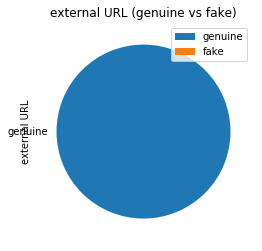

- % external URL fake respecto al total de external URL (naranja): 0.0 %


In [31]:
# Cuantas de ellas son fake?
mask_url_fake = train_data_url['fake'] == 1
train_data_url_fake = train_data_url[mask_url_fake]
n_url_fake = len(train_data_url_fake)
n_url_genuine = n_url - n_url_fake
print("- Nº de cuentas que tienen external URL y son fake: " + str(n_url_fake))

# Representación gráfica
print('\n' + "· Representación gráfica:")
df = pd.DataFrame({'external URL': [n_url_genuine, n_url_fake]}, index=['genuine', 'fake'])
df.plot(y='external URL',kind='pie',title='external URL (genuine vs fake)')
plt.show()

# % respecto el total de external URL
print("- % external URL fake respecto al total de external URL (naranja): " + str((n_url_fake/n_url)*100) + " %")

> Si la cuenta tiene un enlace URL, la cuenta seguramente será auténtica

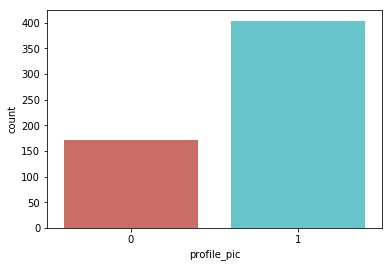

- Nº de cuentas con foto de perfil: 404
- % foto de perfil respecto al total del dataset: 70.13888888888889 %


In [32]:
### Cuantas cuentas tienen foto de perfil?

# - De manera gráfica:
sns.countplot(x='profile_pic',data=train_data, palette="hls")
plt.show()

# - Con números:
mask_profile_pic = train_data['profile_pic'] == 1
train_data_profile_pic = train_data[mask_profile_pic]
n_profile_pic = len(train_data_profile_pic)
print("- Nº de cuentas con foto de perfil: " + str(n_profile_pic))

# % sobre el total del dataset
print("- % foto de perfil respecto al total del dataset: " + str((n_profile_pic/size_dataset)*100) + " %")


> La mayoría de cuentas tienen foto de perfil.

- Nº de cuentas que tienen foto de perfil y son fake: 118

· Representación gráfica:


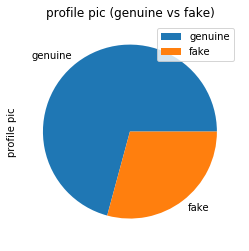

- % foto de perfil fake respecto al total de foto de perfil (naranja): 29.207920792079207 %


In [33]:
# Cuantas de ellas son fake?
mask_pf_fake = train_data_profile_pic['fake'] == 1
train_data_pf_fake = train_data_profile_pic[mask_pf_fake]
n_profile_pic_fake = len(train_data_pf_fake)
n_profile_pic_genuine = n_profile_pic - n_profile_pic_fake
print("- Nº de cuentas que tienen foto de perfil y son fake: " + str(n_profile_pic_fake))

# Representación gráfica
print('\n' + "· Representación gráfica:")
df = pd.DataFrame({'profile pic': [n_profile_pic_genuine, n_profile_pic_fake]}, index=['genuine', 'fake'])
df.plot(y='profile pic',kind='pie',title='profile pic (genuine vs fake)')
plt.show()

# % respecto el total de profile pic
print("- % foto de perfil fake respecto al total de foto de perfil (naranja): " + str((n_profile_pic_fake/n_profile_pic)*100)\
      + " %")


> 3 de cada 10 cuentas que tienen foto de perfil son cuentas fake.

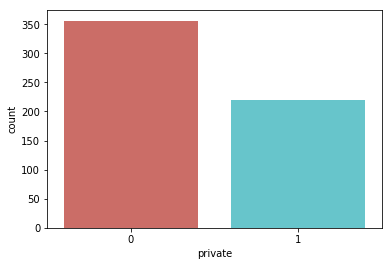

- Nº de cuentas privadas: 220
- % privada respecto al total del dataset: 38.19444444444444 %


In [34]:
### Cuantas cuentas son privadas?

# - De manera gráfica:
sns.countplot(x='private',data=train_data, palette="hls")
plt.show()

# - Con números:
mask_private = train_data['private'] == 1
train_data_private = train_data[mask_private]
n_private = len(train_data_private)
print("- Nº de cuentas privadas: " + str(n_private))

# % sobre el total del dataset
print("- % privada respecto al total del dataset: " + str((n_private/size_dataset)*100) + " %")

> Hay mas cuentas públicas que privadas.

- Nº de cuentas que son privadas y son fake: 106

· Representación gráfica:


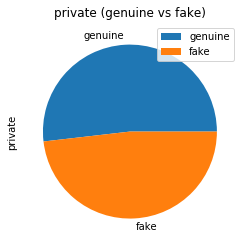

- % privada fake respecto al total de foto de perfil (naranja): 48.18181818181818 %


In [35]:
# Cuantas de ellas son fake?
mask_private_fake = train_data_private['fake'] == 1
train_data_private_fake = train_data_private[mask_private_fake]
n_private_fake = len(train_data_private_fake)
n_private_genuine = n_private - n_private_fake
print("- Nº de cuentas que son privadas y son fake: " + str(n_private_fake))

# Representación gráfica
print('\n' + "· Representación gráfica:")
df = pd.DataFrame({'private': [n_private_genuine, n_private_fake]}, index=['genuine', 'fake'])
df.plot(y='private',kind='pie',title='private (genuine vs fake)')
plt.show()

# % respecto el total de profile pic
print("- % privada fake respecto al total de foto de perfil (naranja): " + str((n_private_fake/n_private)*100)\
      + " %")


> Si la cuenta es privada, tenemos que la mitad són auténticas y la otra mitad son falsas.

In [36]:
### En que posts_cat hay más cuentas fake?
posts_cat_list = ['Unknown','0','1-10','10-50','50-100','100-150','150-200','200-500','500-1k','1k-2k','2k-5k','5k-7k',\
                   '7k-10k']
result_posts_cat = []
dictionary_pc_fake = {}
maximum_pc_fake = 0

def posts_cat_fake(data):
    for i in posts_cat_list:
        global dictionary_pc_fake, maximum_pc_fake # las declaro globales, para acceder a ellas
        mask_pc = train_data['posts_cat'] == i
        train_data_pc = train_data[mask_pc]
        mask_pc_fake = train_data_pc['fake'] == 1
        train_data_pc_fake = train_data_pc[mask_pc_fake]
        n_pc_fake = len(train_data_pc_fake)
        result_posts_cat.append(n_pc_fake)
    dictionary_pc_fake = dict(zip(posts_cat_list,result_posts_cat))
    maximum_pc_fake = max(dictionary_pc_fake, key=dictionary_pc_fake.get)
    return {print("Diccionario con los resultados:" + '\n' + str(dictionary_pc_fake)),
            print('\n' + "- Nº de posts con más cuentas fake: " + str(maximum_pc_fake)),
            print("- Nº de cuentas fake con  " + str(maximum_pc_fake) + " posts: "+ str(dictionary_pc_fake[maximum_pc_fake]))}

posts_cat_fake(train_data)

Diccionario con los resultados:
{'Unknown': 0, '0': 153, '1-10': 93, '10-50': 29, '50-100': 5, '100-150': 7, '150-200': 0, '200-500': 1, '500-1k': 0, '1k-2k': 0, '2k-5k': 0, '5k-7k': 0, '7k-10k': 0}

- Nº de posts con más cuentas fake: 0
- Nº de cuentas fake con  0 posts: 153


{None}

In [37]:
# Quitamos del diccionario las cuentas fake que tienen 0 posts
dictionary_pc_fake.pop('0', None)
dictionary_pc_fake

{'Unknown': 0,
 '1-10': 93,
 '10-50': 29,
 '50-100': 5,
 '100-150': 7,
 '150-200': 0,
 '200-500': 1,
 '500-1k': 0,
 '1k-2k': 0,
 '2k-5k': 0,
 '5k-7k': 0,
 '7k-10k': 0}

In [38]:
# Volvemos a mirar ahora en que posts_cat hay más cuentas fake
maximum_pc_fake = max(dictionary_pc_fake, key=dictionary_pc_fake.get)

print("- Nº de posts con más cuentas fake: " + str(maximum_pc_fake))
print("- Nº de cuentas fake con  " + str(maximum_pc_fake) + " posts: " + str(dictionary_pc_fake[maximum_pc_fake]))

- Nº de posts con más cuentas fake: 1-10
- Nº de cuentas fake con  1-10 posts: 93


> Vemos que si una cuenta es fake tiene pocos posts o directamente no tiene.

In [39]:
# Y las cuentas auténticas, que rango de posts es más típico?
def posts_cat_real(data):
    results_posts_real = []
    for i in posts_cat_list:
        mask_pc1 = train_data['posts_cat'] == i
        train_data_pc1 = train_data[mask_pc1]
        mask_pc_real = train_data_pc1['fake'] == 0
        train_data_pc_real = train_data_pc1[mask_pc_real]
        n_pc_real = len(train_data_pc_real)
        results_posts_real.append(n_pc_real)
    dict_posts_real = dict(zip(posts_cat_list,results_posts_real))
    maximum_pc_real = max(dict_posts_real, key=dict_posts_real.get)
    return {print("Diccionario con los resultados:" + '\n' + str(dict_posts_real)),
            print('\n' + "- Nº de posts más típico de cuentas auténticas: " + str(maximum_pc_real))}

posts_cat_real(train_data)

Diccionario con los resultados:
{'Unknown': 0, '0': 4, '1-10': 46, '10-50': 63, '50-100': 56, '100-150': 29, '150-200': 13, '200-500': 49, '500-1k': 21, '1k-2k': 5, '2k-5k': 1, '5k-7k': 0, '7k-10k': 1}

- Nº de posts más típico de cuentas auténticas: 10-50


{None}

> Podemos observar que si una cuenta es auténtica lo más seguro es que tenga algun post, y lo más común es que tenga entre 10 y 50 posts.

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 10 Text xticklabel objects>)

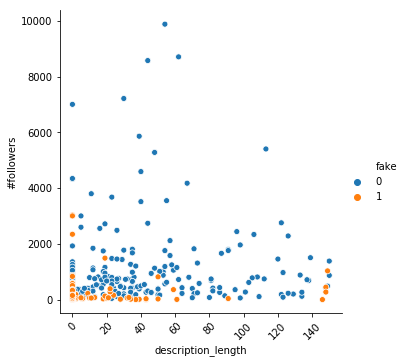

In [40]:
### Grafico description_length vs followers (y si es fake o no)
sns.relplot(x="description_length", y="#followers", hue="fake", kind="scatter", data=train_data_mask1);
plt.xticks(rotation=45)

> Las cuentas falsas aunque tengan descripción, no tienen muchos followers, comparado con las auténticas.

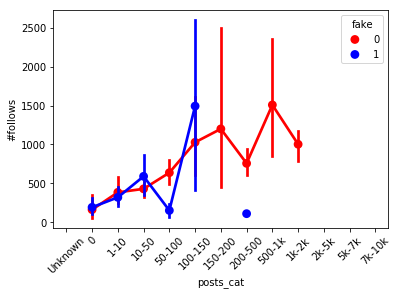

In [41]:
### Gráfico posts_cat vs follows (y si es fake o no)
sns.pointplot(x='posts_cat',y='#follows', hue = 'fake',palette={0:'red', 1:'blue'}, data=train_data_mask1)
plt.xticks(rotation=45)
plt.show()

> En términos generales tanto si la cuenta es falsa o no ,vemos que las cuentas que tienen mas posts son las que siguen a más gente. Aunque con las cuentas fake, no se cumple esto con 50-100 posts.

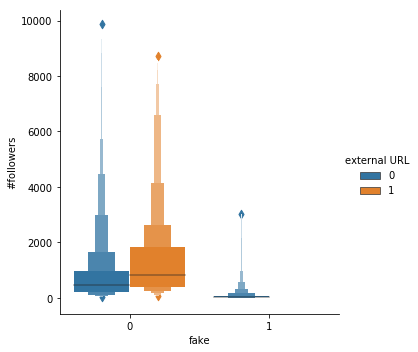

In [42]:
### Gráfico fake vs followers (y si tiene external URL o no)
sns.catplot(x="fake", y="#followers", hue="external URL", data=train_data_mask1, kind='boxen')
plt.show()

> Las cuentas auténticas que tienen external URL ligeramente tienen mas followers, aunque la cuenta que tiene más followers (sobre 10k de followers) no tiene external URL. Como vimos antes, las cuentas fake no tienen external URL.

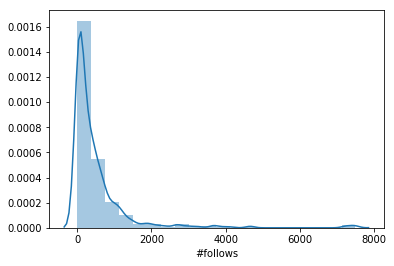

In [43]:
### Gráfico de follows (histograma y densidad)
sns.distplot(train_data['#follows'],kde=True,bins=20);
plt.show()

> Vemos que hay más cuentas con menos follows y el número de follows más usual está entre 0 y 1000 aproximadamente. Así que vamos mirar de más de cerca esta region.

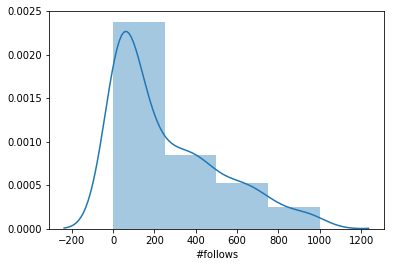

In [44]:
# Gráfico de follows (filtrado)
filter_var = 1000
mask_follows = train_data['#follows'] < filter_var
train_data_follows = train_data[mask_follows]
sns.distplot(train_data_follows['#follows'],kde=True,bins=4);
plt.show()

> Ahora podemos apreciar mejor donde estan concentrados el número de follows en general de las cuentas.

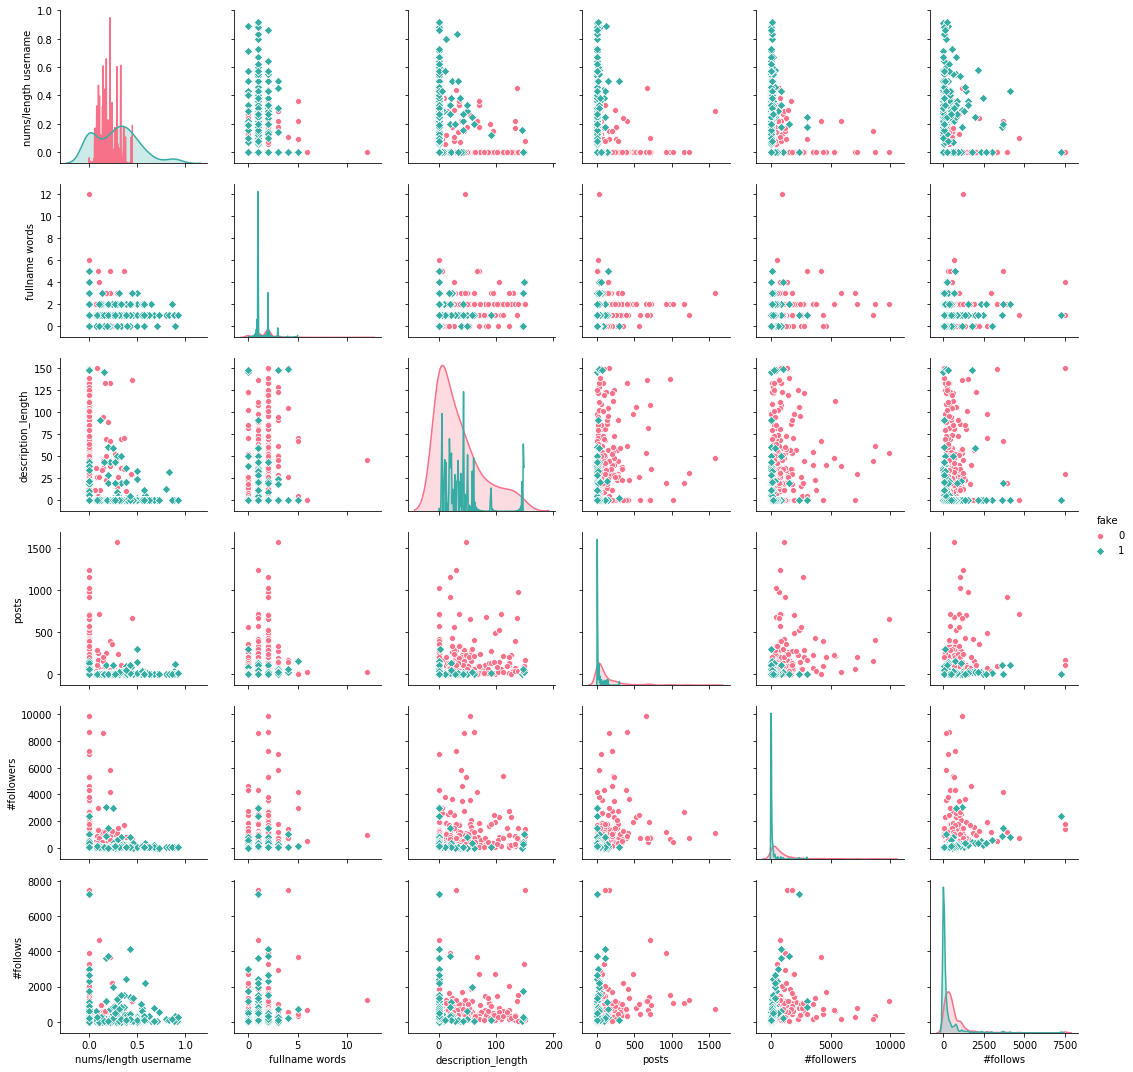

In [45]:
### Graficos de variables no binarias (y si es fake o no)
sns.pairplot(train_data_mask1, hue="fake", palette="husl", markers=["o", "D"], vars = ('nums/length username',\
                                        'fullname words','description_length','posts', '#followers','#follows'))
plt.show()

<font size="4">__Procesamiento de datos:__</font>
> Crearé un dataframe con nombres (y su edad) y países random de las cuentas con valores Nan.

In [46]:
### Dataframe con nombres y países random
random_names = ['Carlos(11)', 'Jose(12)', 'Alberto(14)', 'Antonio(15)', 'Eduardo (16)','Laura(18)', 'Eva(19)',\
                'Luisa(20)', 'Matilde(21)', 'Sofia(22)', np.nan]
random_countries = ['Spain', 'Italy', 'England', 'France', 'Netherlands', 'Belgium','EEUU','Japan','Greece','Portugal', np.nan]

result_names_list = []
result_countries_list = []

for i in range(size_dataset_test):
    result_names_list.append(random.choice(random_names))
    result_countries_list.append(random.choice(random_countries))

data_name_countries = {'name': result_names_list, 'country': result_countries_list}
df_name_countries = pd.DataFrame(data_name_countries)
df_name_countries.sample(10)

,name,country
11,Carlos(11),NaN
87,Carlos(11),Belgium
91,Matilde(21),Spain
22,NaN,Japan
81,Alberto(14),England
85,Eduardo (16),Japan
108,Eduardo (16),England
47,NaN,EEUU
36,Eva(19),NaN
57,Antonio(15),Portugal


In [47]:
### Lo combinamos con el dataset de test_data
combined_dataset = pd.merge(test_data, df_name_countries, left_index=True, right_index=True)
combined_dataset.sample(10)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,name,country
21,1,0.00,0,0.00,0,28,0,1,58,486,862,0,Sofia(22),Japan
86,1,0.00,3,0.00,0,58,0,0,4,1742,6172,1,Alberto(14),NaN
46,1,0.00,2,0.00,0,8,0,1,85,668,605,0,Antonio(15),Portugal
29,1,0.00,2,0.00,0,147,1,0,1879,4021842,5514,0,Sofia(22),Portugal
30,1,0.00,2,0.00,0,0,0,0,9,366,552,0,NaN,England
112,0,0.44,1,0.00,0,0,0,0,0,13,7,1,Carlos(11),Italy
38,1,0.00,1,0.00,0,0,1,0,14,264,151,0,Eva(19),England
36,1,0.00,2,0.30,0,18,0,0,59,855,151,0,Eva(19),NaN
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1,Alberto(14),Greece
111,1,0.00,1,0.25,0,0,0,0,0,49,235,1,Eduardo (16),Japan


In [48]:
### Valores nulos (Nan)
# Cantidad de filas con valores nulos
print("- Nº de filas con valores nulos: "+ str(combined_dataset.isnull().sum().sum()))

# Número de nulos por fila
print('\n' + "- Nº de nulos por fila: "+ '\n' + str(combined_dataset.shape[1] - combined_dataset.count(axis=1)))

# Cantidad de nulos por columna
combined_dataset.isna().sum()
print('\n' + "- Nº de nulos por columna: "+'\n'+ str(combined_dataset.isna().sum()))

- Nº de filas con valores nulos: 25

- Nº de nulos por fila: 
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      1
8      0
9      0
10     0
11     1
12     0
13     2
14     0
15     1
16     0
17     0
18     1
19     0
20     0
21     0
22     1
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
90     0
91     0
92     0
93     0
94     1
95     1
96     0
97     0
98     0
99     0
100    0
101    0
102    1
103    0
104    0
105    2
106    0
107    0
108    0
109    0
110    0
111    0
112    0
113    0
114    0
115    0
116    0
117    0
118    0
119    0
Length: 120, dtype: int64

- Nº de nulos por columna: 
profile pic              0
nums/length username     0
fullname words           0
nums/length fullname     0
name==username           0
description length       0
external URL             0
private                  0
#posts                   0
#followers               0
#follows                 0
fake                     0
name      

In [49]:
# Quitamos las filas con valores nulos
combined_dataset_whitout_nan = combined_dataset.dropna()
# Y Hacemos un reset en el indice
combined_dataset_clean = combined_dataset_whitout_nan.reset_index(drop = True)

In [50]:
combined_dataset_clean.head(10)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,name,country
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0,Antonio(15),Greece
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0,Carlos(11),England
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0,Carlos(11),Belgium
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0,Alberto(14),Netherlands
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0,Jose(12),Netherlands
5,1,0.00,1,0.00,0,0,0,1,6,362,424,0,Eva(19),EEUU
6,1,0.00,1,0.00,0,132,0,1,9,213,254,0,Carlos(11),Italy
7,1,0.00,2,0.00,0,96,0,1,17,122,143,0,Laura(18),Netherlands
8,1,0.00,1,0.00,0,78,0,1,9,834,358,0,Carlos(11),EEUU
9,1,0.00,1,0.00,0,0,0,1,53,229,492,0,Antonio(15),Spain


In [51]:
# Tamaño del dataset sin los valores nulos
print("Tamaño del dataset sin los valores nulos (filas): " + str(len(combined_dataset_clean)))

Tamaño del dataset sin los valores nulos (filas): 97


In [52]:
### De la columna name, separamos nombre y año en dos columnas distintas
results_age = []

for i in range(len(combined_dataset_clean)):
    s = combined_dataset_clean.name[i]
    results_age.append(s[s.find("(")+1:s.find(")")])
results_age

combined_dataset_clean.insert(13, 'age', results_age)

In [53]:
# Quitamos el año de la columna name
combined_dataset_clean['name'] = combined_dataset_clean['name'].str.replace(r"\(.*\)", '')

In [54]:
combined_dataset_clean.sample(10)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,name,age,country
53,0,0.00,1,0.0,0,0,0,0,0,23,33,1,Sofia,22,France
66,0,0.00,1,0.0,0,0,0,0,0,21,31,1,Sofia,22,Netherlands
83,1,0.89,2,0.0,0,0,0,0,6,192,942,1,Laura,18,England
75,0,0.00,1,0.0,0,0,0,0,2,37,58,1,Sofia,22,Japan
61,0,0.75,1,1.0,0,0,0,0,0,227,353,1,Matilde,21,EEUU
4,1,0.50,1,0.0,0,76,0,1,6,225,356,0,Jose,12,Netherlands
52,0,0.00,1,0.0,1,0,0,0,0,69,694,1,Carlos,11,France
87,1,0.00,1,0.0,0,0,0,0,1,193,669,1,Alberto,14,Portugal
15,1,0.50,1,0.0,0,0,0,1,0,189,276,0,Jose,12,England
60,0,0.50,2,0.0,0,0,0,0,0,13,22,1,Carlos,11,England


In [55]:
### Miramos los followers de cada país (y si es fake o no)
combined_dataset_clean.pivot_table('#followers', index='fake', columns='country')

country,Belgium,EEUU,England,France,Greece,Italy,Japan,Netherlands,Portugal,Spain
fake,,,,,,,,,,
0,1241.000000,565.250000,307.500000,121182.00,39120.50,317.0,618.5,13929.714286,670719.166667,309.250000
1,371.166667,91.166667,362.285714,804.25,79.25,62.5,176.8,30.250000,214.500000,88.333333


In [56]:
### Cuantos nombres con Alberto contiene el dataset?
alberto_name = combined_dataset_clean[ combined_dataset_clean['name'].str.contains('Alberto') ]
len(alberto_name)

9

In [57]:
# Algun alberto es de un país en concreto, por ejemplo Italy?
country = 'Italy' # modificar para cambiar de país
filtro = filter(lambda x : country in x, alberto_name['country'])
filtro_list = list(filtro)
if (len(filtro_list)) > 0:
    print("Si, hay "+ str(len(filtro_list) ) + " de Italy" )
else: 
    print("No")

Si, hay 1 de Italy


In [58]:
### La columna fake la passamo a bool
fake_bool = map(lambda x : bool(x), combined_dataset_clean['fake'])
combined_dataset_clean.loc[:,'fake'] = list(fake_bool)
combined_dataset_clean.head(4)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,name,age,country
0,1,0.33,1,0.33,1,30,0,1,35,488,604,False,Antonio,15,Greece
1,1,0.00,5,0.00,0,64,0,1,3,35,6,False,Carlos,11,England
2,1,0.00,2,0.00,0,82,0,1,319,328,668,False,Carlos,11,Belgium
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,False,Alberto,14,Netherlands
